In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import librosa
import scipy
import torch
import torch.nn.functional as F
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
import requests
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
speech1="https://dashpulsar.github.io/BrainlikeASR/ALL_055_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.wav"
speech2="https://dashpulsar.github.io/BrainlikeASR/ALL_066_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.wav"
response1 = requests.get(speech1)
response2 = requests.get(speech2)
if response1.status_code == 200:
    audio_file1 = BytesIO(response1.content)
    audio_data1, sr = librosa.load(audio_file1)
    wave_res1 = librosa.resample(audio_data1, orig_sr=sr, target_sr=16000)
if response2.status_code == 200:
    audio_file2 = BytesIO(response2.content)
    audio_data2, sr = librosa.load(audio_file2)
    wave_res2 = librosa.resample(audio_data2, orig_sr=sr, target_sr=16000)

## Audio alignment, test on sentence level

### Original Spectrogram 

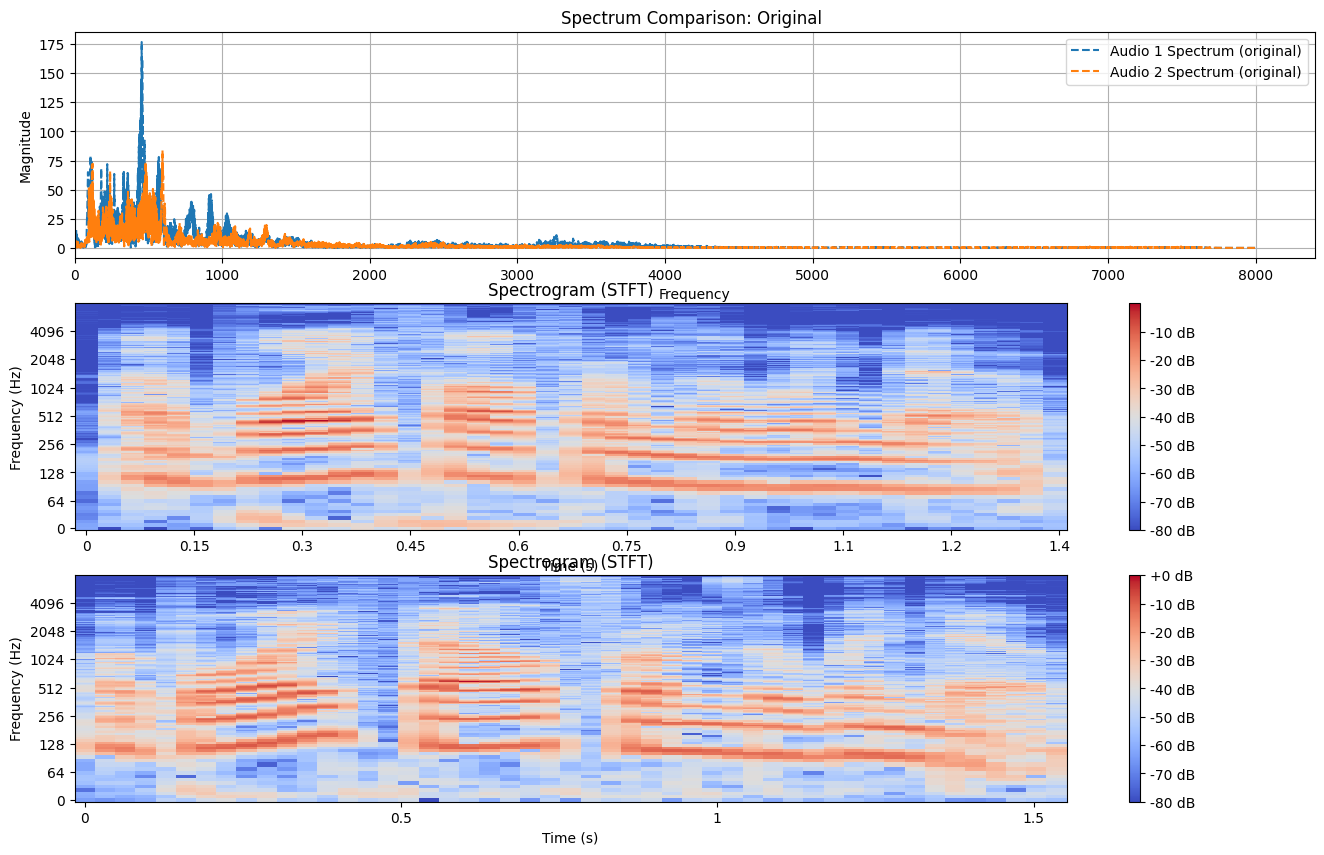

In [3]:
from scipy.fft import fft

spectrum1 = np.abs(fft(wave_res1))
spectrum2 = np.abs(fft(wave_res2))

target_length = max(len(wave_res1), len(wave_res2))
freqs_padded = np.fft.fftfreq(target_length)
sampling_rate = 16000
freqs1 = np.fft.fftfreq(len(wave_res1), d=1/sampling_rate)
freqs2 = np.fft.fftfreq(len(wave_res2), d=1/sampling_rate)

def get_norm_log_spectrogram(audio):
    spectrogram = np.abs(librosa.stft(audio, n_fft=512, hop_length=256)[:-1])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    #norm_log_spectrogram = normaliser.normalise(log_spectrogram)
    return log_spectrogram#norm_log_spectrogram


plt.figure(figsize=(16, 10))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(wave_res1) // 2], spectrum1[:len(wave_res1) // 2], label='Audio 1 Spectrum (original)', linestyle='--')
plt.plot(freqs2[:len(wave_res2) // 2], spectrum2[:len(wave_res2) // 2], label='Audio 2 Spectrum (original)', linestyle='--')
plt.title('Spectrum Comparison: Original ')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(wave_res1)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=wave_res1, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(wave_res2)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=wave_res2, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.show()

### DTW Spectrogram 

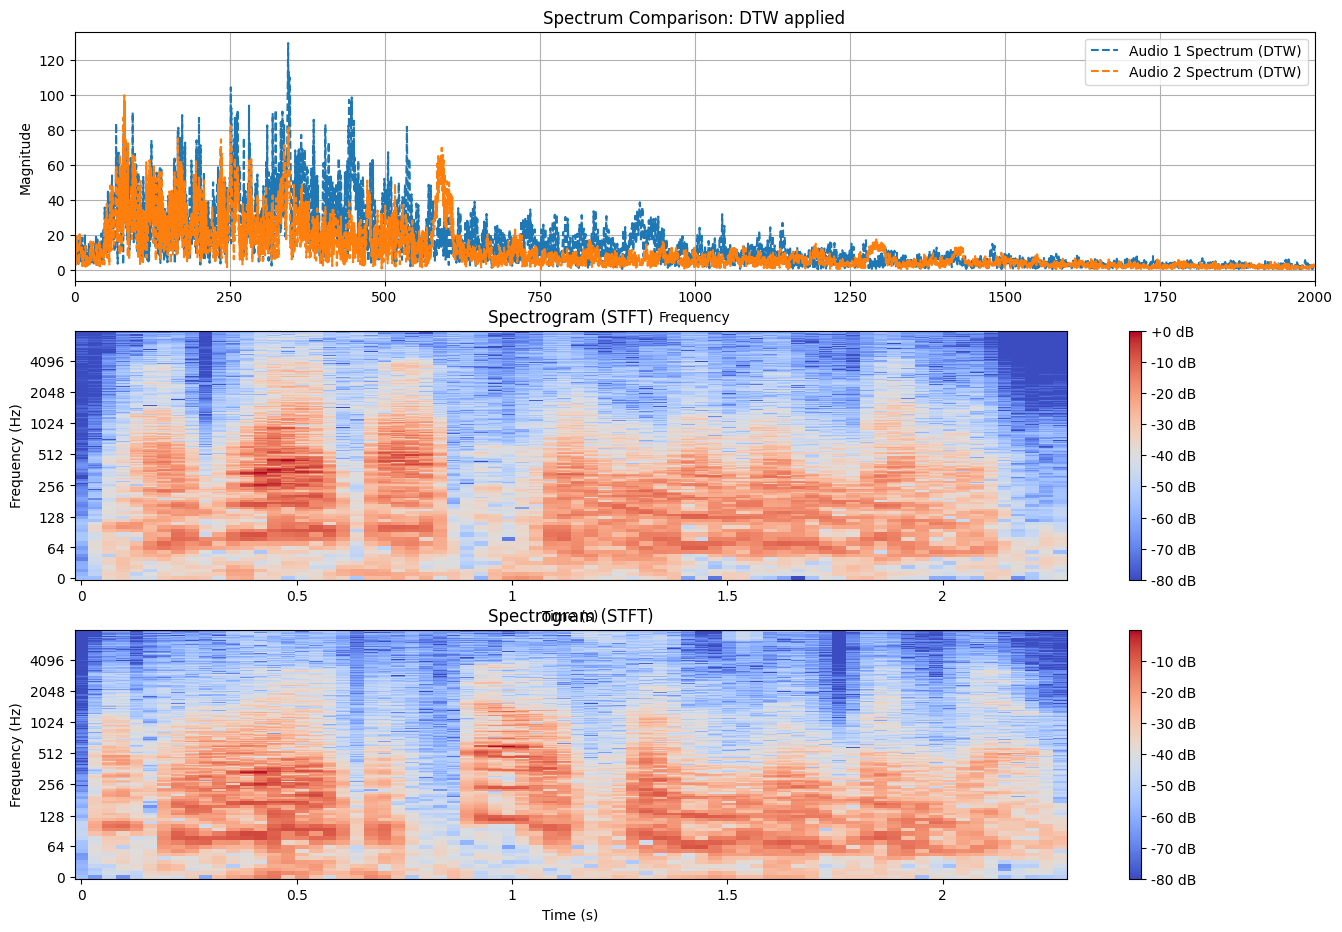

In [11]:
from scipy.interpolate import interp1d


'''distance, path = fastdtw(wave_res1, wave_res2)


short_indices, long_indices = zip(*path)
aligned_short_audio = np.array([wave_res1[i] for i in short_indices])

interp_func = interp1d(range(len(aligned_short_audio)), aligned_short_audio, kind='linear', fill_value="extrapolate")
stretched_short_audio = interp_func(np.linspace(0, len(aligned_short_audio) - 1, len(wave_res2)))
audio1_aligned ,audio2_aligned =stretched_short_audio,wave_res2
target_length = max(len(audio1_aligned), len(audio2_aligned))
'''

from scipy.spatial.distance import euclidean

distance, path = fastdtw(wave_res1.reshape(-1,1), wave_res2.reshape(-1,1), dist=euclidean)
audio1_aligned = []
audio2_aligned = []
for idx1, idx2 in path:
    audio1_aligned.append(wave_res1[idx1])
    audio2_aligned.append(wave_res2[idx2])
audio1_aligned = np.array(audio1_aligned)
audio2_aligned = np.array(audio2_aligned)


spectrum1 = np.abs(fft(audio1_aligned))
spectrum2 = np.abs(fft(audio2_aligned))

target_length = max(len(audio1_aligned), len(audio2_aligned))
freqs_padded = np.fft.fftfreq(target_length)
sampling_rate = 16000
freqs1 = np.fft.fftfreq(len(audio1_aligned), d=1/sampling_rate)
freqs2 = np.fft.fftfreq(len(audio2_aligned), d=1/sampling_rate)
plt.figure(figsize=(16, 11))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(audio1_aligned) // 2], spectrum1[:len(audio1_aligned) // 2], label='Audio 1 Spectrum (DTW)', linestyle='--')
plt.plot(freqs2[:len(audio2_aligned) // 2], spectrum2[:len(audio2_aligned) // 2], label='Audio 2 Spectrum (DTW)', linestyle='--')
plt.title('Spectrum Comparison: DTW applied')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0,2000)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(audio1_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio1_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(audio2_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio2_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

### Linear Interpolate

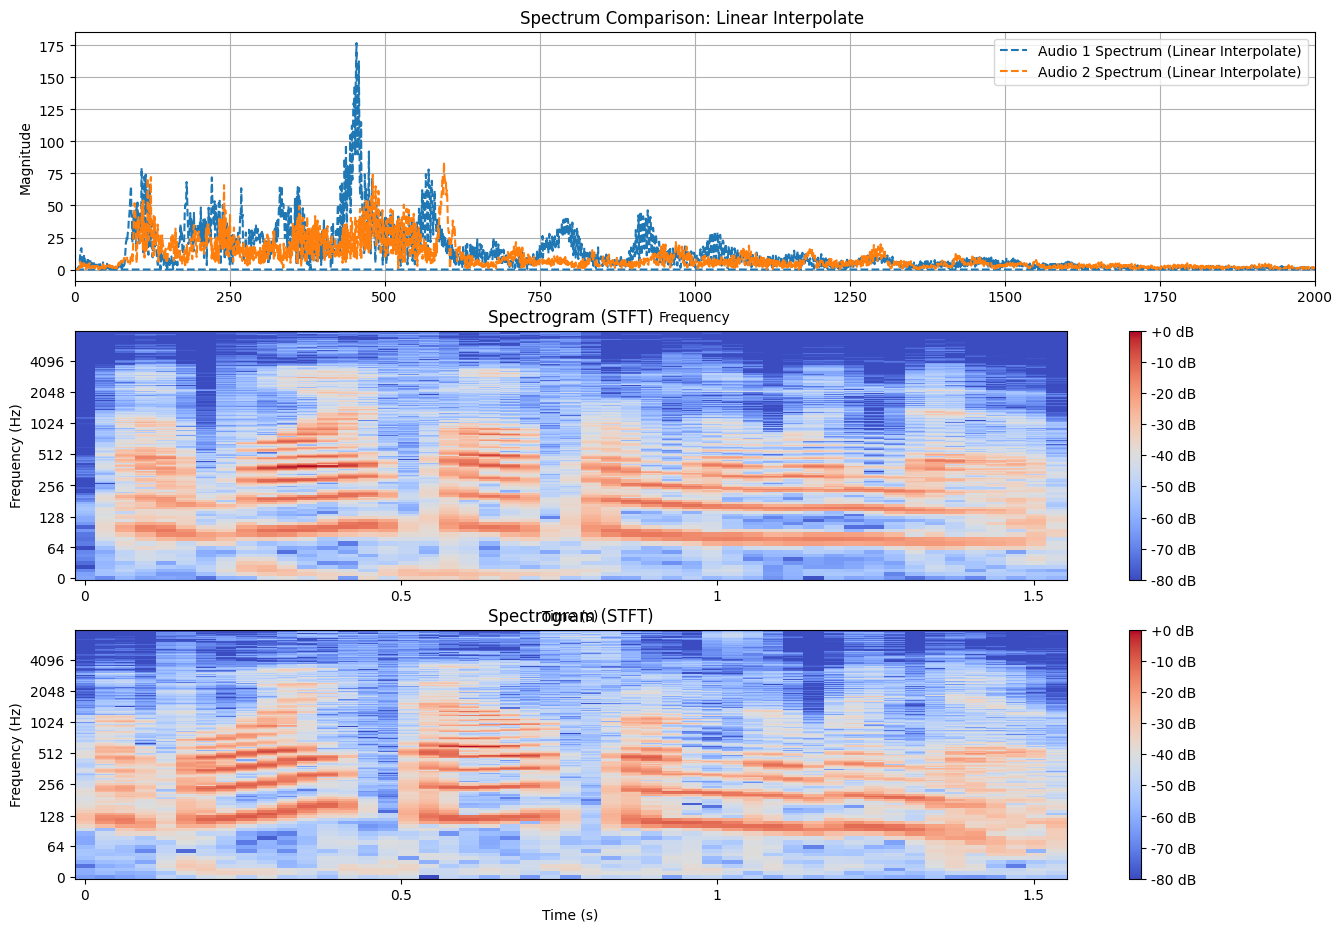

In [6]:
def alignment(audio1,audio2):
    
    audio_tensor_1 = torch.tensor(audio1).unsqueeze(0).unsqueeze(0)  
    audio_tensor_2 = torch.tensor(audio2).unsqueeze(0).unsqueeze(0)

    max_length = max(audio_tensor_1.shape[-1], audio_tensor_2.shape[-1])
    if audio_tensor_1.shape[-1] < max_length:
        audio_tensor_1 = F.interpolate(audio_tensor_1, size=max_length, mode='linear', align_corners=False)
    else:
        audio_tensor_2 = F.interpolate(audio_tensor_2, size=max_length, mode='linear', align_corners=False)
    aligned_audio_1 = audio_tensor_1.squeeze()
    aligned_audio_2 = audio_tensor_2.squeeze()
    return aligned_audio_1.numpy(), aligned_audio_2.numpy()

audio1_aligned ,audio2_aligned =alignment(wave_res1,wave_res2)
target_length = max(len(audio1_aligned), len(audio2_aligned))

plt.figure(figsize=(16, 11))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(audio1_aligned) // 2], spectrum1[:len(audio1_aligned) // 2], label='Audio 1 Spectrum (Linear Interpolate)', linestyle='--')
plt.plot(freqs2[:len(audio2_aligned) // 2], spectrum2[:len(audio2_aligned) // 2], label='Audio 2 Spectrum (Linear Interpolate)', linestyle='--')
plt.title('Spectrum Comparison: Linear Interpolate ')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0,2000)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(audio1_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio1_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(audio2_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio2_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Audio alignment, test on Word level

### Cut the word "Window"

In [13]:
speech1="https://dashpulsar.github.io/BrainlikeASR/ALL_055_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.wav"
speech2="https://dashpulsar.github.io/BrainlikeASR/ALL_066_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.wav"
response1 = requests.get(speech1)
response2 = requests.get(speech2)
if response1.status_code == 200:
    audio_file1 = BytesIO(response1.content)
    audio_data1, sr = librosa.load(audio_file1)
    wave_res1 = librosa.resample(audio_data1, orig_sr=sr, target_sr=16000)
if response2.status_code == 200:
    audio_file2 = BytesIO(response2.content)
    audio_data2, sr = librosa.load(audio_file2)
    wave_res2 = librosa.resample(audio_data2, orig_sr=sr, target_sr=16000)
    
npy1 = "https://dashpulsar.github.io/BrainlikeASR/ALL_055_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.npy"
npy2 = "https://dashpulsar.github.io/BrainlikeASR/ALL_066_M_ENG_ENG_A_BOY_FELL_FROM_A_WINDOW.npy"
response3 = requests.get(npy1)
response4 = requests.get(npy2)
if response3.status_code == 200:
    npy_file1 = BytesIO(response3.content)
    npy1 = np.load(npy_file1)
if response4.status_code == 200:
    npy_file2 = BytesIO(response4.content)
    npy2 = np.load(npy_file2)

df1 = pd.DataFrame(npy1)
df_word1=np.array(df1[df1[0]=="word"])

df2 = pd.DataFrame(npy2)
df_word2=np.array(df2[df2[0]=="word"])

audio1=wave_res1[int(float(df_word1[-1][1])*16000):int(float(df_word1[-1][2])*16000)]
audio2=wave_res2[int(float(df_word2[-1][1])*16000):int(float(df_word2[-1][2])*16000)]




### Original Spectrogram 

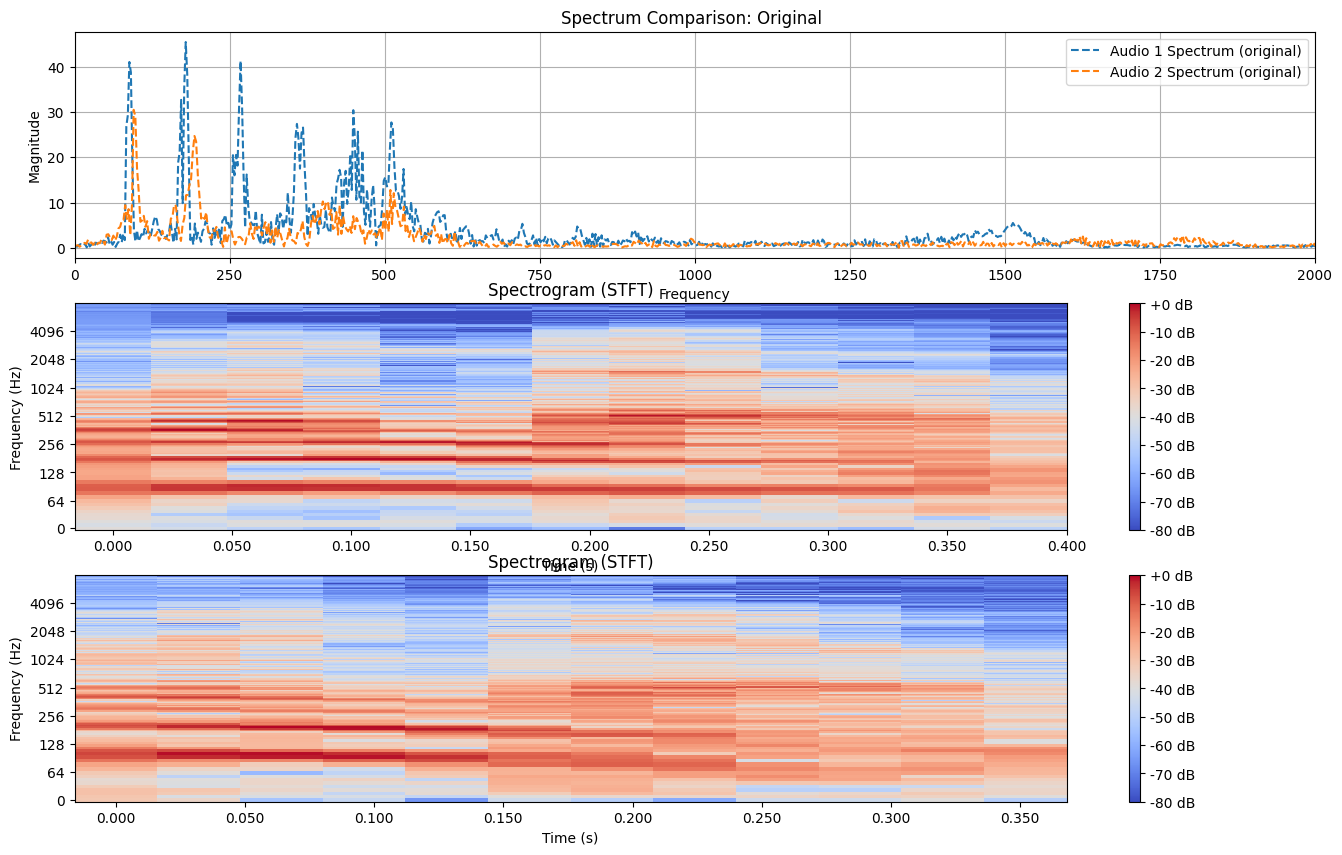

In [8]:
from scipy.fft import fft

spectrum1 = np.abs(fft(audio1))
spectrum2 = np.abs(fft(audio2))

target_length = max(len(audio1), len(audio2))
freqs_padded = np.fft.fftfreq(target_length)
sampling_rate = 16000
freqs1 = np.fft.fftfreq(len(audio1), d=1/sampling_rate)
freqs2 = np.fft.fftfreq(len(audio2), d=1/sampling_rate)

def get_norm_log_spectrogram(audio):
    spectrogram = np.abs(librosa.stft(audio, n_fft=512, hop_length=256)[:-1])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    #norm_log_spectrogram = normaliser.normalise(log_spectrogram)
    return log_spectrogram#norm_log_spectrogram


plt.figure(figsize=(16, 10))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(audio1) // 2], spectrum1[:len(audio1) // 2], label='Audio 1 Spectrum (original)', linestyle='--')
plt.plot(freqs2[:len(audio2) // 2], spectrum2[:len(audio2) // 2], label='Audio 2 Spectrum (original)', linestyle='--')
plt.xlim(0,2000)
plt.title('Spectrum Comparison: Original ')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(audio1)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio1, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(audio2)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio2, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.show()

### DTW Spectrogram 

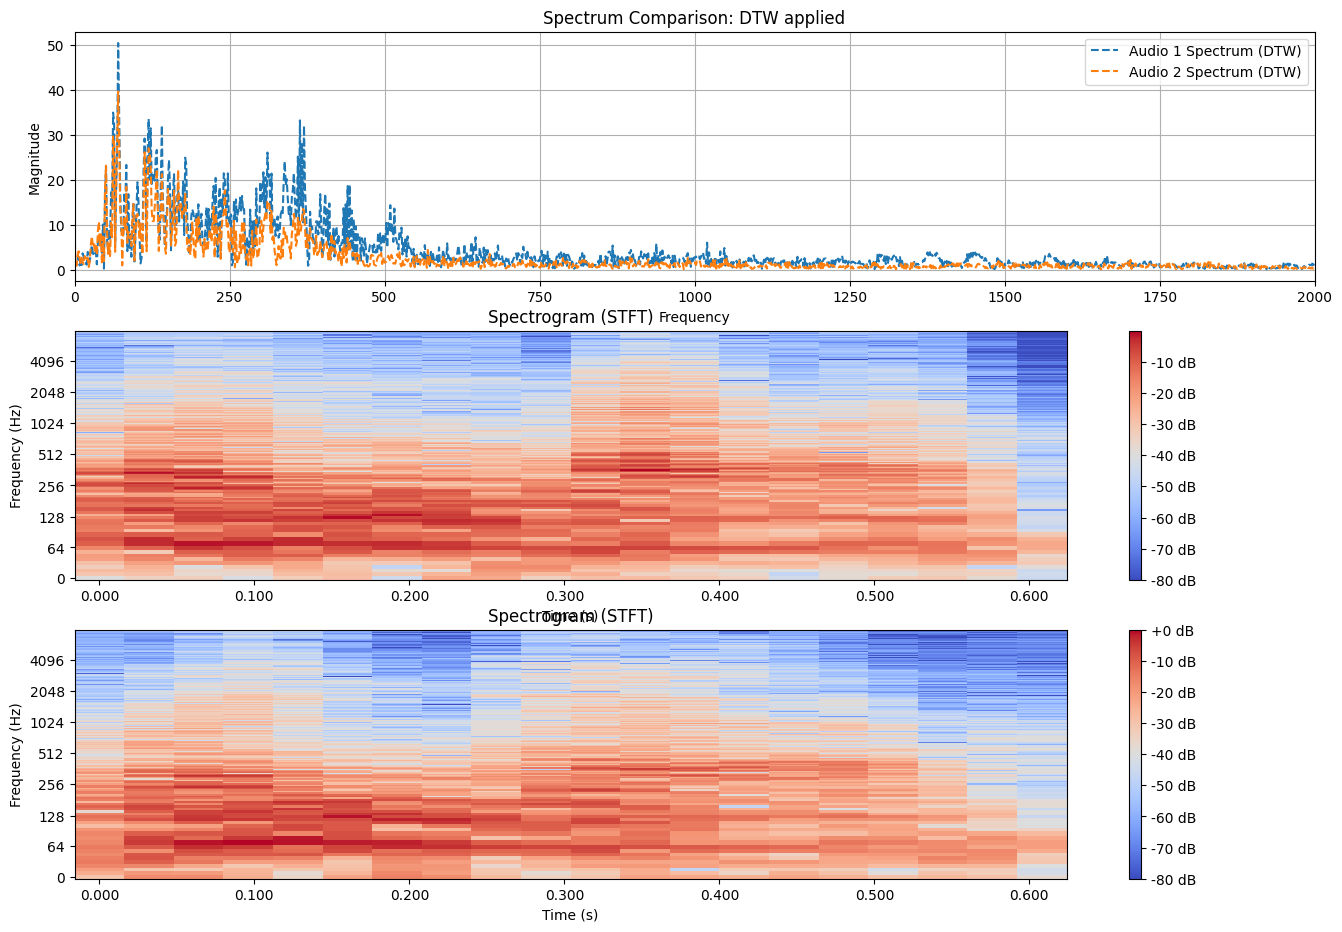

In [14]:
from scipy.interpolate import interp1d


from scipy.spatial.distance import euclidean

distance, path = fastdtw(audio1.reshape(-1,1), audio2.reshape(-1,1), dist=euclidean)
audio1_aligned = []
audio2_aligned = []
for idx1, idx2 in path:
    audio1_aligned.append(audio1[idx1])
    audio2_aligned.append(audio2[idx2])
audio1_aligned = np.array(audio1_aligned)
audio2_aligned = np.array(audio2_aligned)


spectrum1 = np.abs(fft(audio1_aligned))
spectrum2 = np.abs(fft(audio2_aligned))

target_length = max(len(audio1_aligned), len(audio2_aligned))
freqs_padded = np.fft.fftfreq(target_length)
sampling_rate = 16000
freqs1 = np.fft.fftfreq(len(audio1_aligned), d=1/sampling_rate)
freqs2 = np.fft.fftfreq(len(audio2_aligned), d=1/sampling_rate)

plt.figure(figsize=(16, 11))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(audio1_aligned) // 2], spectrum1[:len(audio1_aligned) // 2], label='Audio 1 Spectrum (DTW)', linestyle='--')
plt.plot(freqs2[:len(audio2_aligned) // 2], spectrum2[:len(audio2_aligned) // 2], label='Audio 2 Spectrum (DTW)', linestyle='--')
plt.title('Spectrum Comparison: DTW applied')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0,2000)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(audio1_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio1_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(audio2_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio2_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

### Linear Interpolate

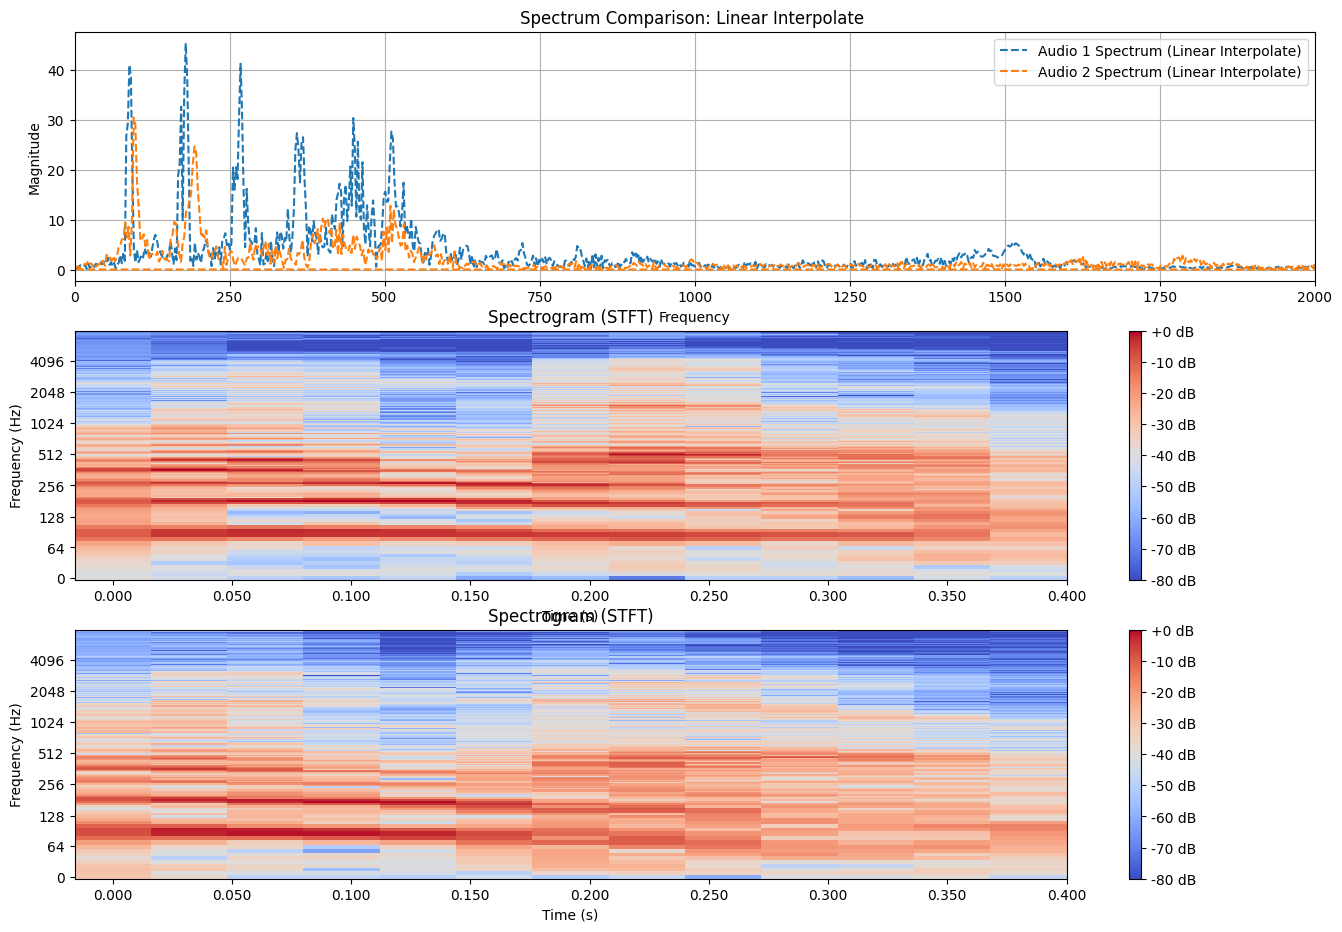

In [10]:
def alignment(audio1,audio2):
    
    audio_tensor_1 = torch.tensor(audio1).unsqueeze(0).unsqueeze(0)  
    audio_tensor_2 = torch.tensor(audio2).unsqueeze(0).unsqueeze(0)

    max_length = max(audio_tensor_1.shape[-1], audio_tensor_2.shape[-1])
    if audio_tensor_1.shape[-1] < max_length:
        audio_tensor_1 = F.interpolate(audio_tensor_1, size=max_length, mode='linear', align_corners=False)
    else:
        audio_tensor_2 = F.interpolate(audio_tensor_2, size=max_length, mode='linear', align_corners=False)
    aligned_audio_1 = audio_tensor_1.squeeze()
    aligned_audio_2 = audio_tensor_2.squeeze()
    return aligned_audio_1.numpy(), aligned_audio_2.numpy()

audio1_aligned ,audio2_aligned =alignment(audio1,audio2)
target_length = max(len(audio1_aligned), len(audio2_aligned))

plt.figure(figsize=(16, 11))
plt.subplot(3, 1, 1)
plt.plot(freqs1[:len(audio1_aligned) // 2], spectrum1[:len(audio1_aligned) // 2], label='Audio 1 Spectrum (Linear Interpolate)', linestyle='--')
plt.plot(freqs2[:len(audio2_aligned) // 2], spectrum2[:len(audio2_aligned) // 2], label='Audio 2 Spectrum (Linear Interpolate)', linestyle='--')
plt.title('Spectrum Comparison: Linear Interpolate ')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0,2000)
plt.legend()
plt.grid(True)



sr=16000
plt.subplot(3, 1, 2)
D = librosa.stft(audio1_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio1_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')


plt.subplot(3, 1, 3)
D = librosa.stft(audio2_aligned)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_mel = librosa.feature.melspectrogram(y=audio2_aligned, sr=sr, n_mels=512, fmax=8000)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()